In [693]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as pyo
import plotly.graph_objs as go
import glob
import math
import os

In [767]:
DUMP_ID = 500

In [768]:
PATH_PREFIX = "/mnt/storage/data/vision/imagenet/training_dumps/" + str(DUMP_ID).zfill(8)

### Parameters

In [634]:
def get_values_from_files(filenames):
    arr = []
    for f in filenames:
        arr.append(np.fromfile(f, dtype=np.float32))
    return arr

In [769]:
model_param_buffer_filenames = sorted(glob.glob(PATH_PREFIX + "/model_params/*"))
gradient_buffer_filenames = sorted(glob.glob(PATH_PREFIX + "/gradients/*"))
mean_buffer_filenames = sorted(glob.glob(PATH_PREFIX + "/means/*"))
var_buffer_filenames = sorted(glob.glob(PATH_PREFIX + "/vars/*"))

In [770]:
model_params_list = get_values_from_files(model_param_buffer_filenames)
gradients_list = get_values_from_files(gradient_buffer_filenames)
means_list = get_values_from_files(mean_buffer_filenames)
vars_list = get_values_from_files(var_buffer_filenames)

In [ ]:
for i in range(212, -1, -1):
    print("[" + str(min(gradients_list[i])) + "-" + str(max(gradients_list[i])) + "]")

### Forward Activations

In [18]:
def gather_batch_norm_data(dir_name):
    data_list = []
    for s in ["reduced", "spatial", "expanded"]:
        for f in ["means.buffer", "vars.buffer", "norm_temp.buffer", "norm.buffer"]:
            data = np.fromfile(dir_name + "/" + s + "/" + f, dtype=np.float32)
            data_list.append(data)
    return data_list

In [19]:
def gather_convblock_data(dir_name):
    data_list = []
    for f in ["reduction_applied.buffer", "reduction_activated.buffer", "spatial_applied.buffer", "spatial_activated.buffer", "expanded_applied.buffer", "combined_output.buffer", "output_activated.buffer"]:
        data = np.fromfile(dir_name + "/" + f, dtype=np.float32)
        data_list.append(data)
    return data_list

#### Initial Conv Layer and MaxPool

In [792]:
input_images = np.fromfile(PATH_PREFIX + "/activations/input.buffer", dtype=np.float32)
correct_classes = np.fromfile(PATH_PREFIX + "/activations/correct_classes.buffer", dtype=np.int32)
init_conv_applied = np.fromfile(PATH_PREFIX + "/activations/init_conv_applied.buffer", dtype=np.float32)
init_conv_activated = np.fromfile(PATH_PREFIX + "/activations/init_conv_activated.buffer", dtype=np.float32)
max_inds = np.fromfile(PATH_PREFIX + "/activations/max_inds.buffer", dtype=np.int32)
init_convblock_input = np.fromfile(PATH_PREFIX + "/activations/init_convblock_input.buffer", dtype=np.float32)

In [793]:
input_images_shaped = np.reshape(input_images, (32, 224, 224, 3))
correct_classes_shaped = np.reshape(correct_classes, (32))

In [794]:
with open('id_to_label_mapping.txt') as f:
    label_descriptions = [line.rstrip() for line in f]

In [798]:
# Red: 103.94
# Green: 116.78
# Blue: 123.68
def show_img(img_num, values, correct_labels, label_strings):
    img = np.copy(input_images_shaped[img_num, :])
    img[:, :, 0] = img[:, :, 0] + 103.94
    img[:, :, 1] = img[:, :, 1] + 116.78
    img[:, :, 2] = img[:, :, 2] + 123.68
    img_ints = img.astype(int)
    correct_label_ind = correct_labels[img_num]
    label_desc = label_strings[correct_label_ind]
    print("\nLABEL: " + label_desc + "\n")
    plt.imshow(img_ints)


LABEL: sandbar



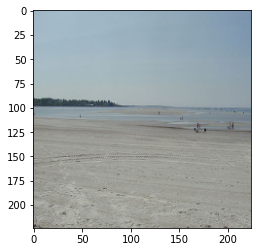

In [802]:
show_img(28, input_images_shaped, correct_classes_shaped, label_descriptions)

In [715]:
init_conv_applied_shaped = np.reshape(init_conv_applied, (32, 112, 112, 64))

In [716]:
init_conv_applied_shaped[0, :]

array([[[-0.8793858 , -2.0541258 ,  5.457314  , ...,  2.4655561 ,
         -0.7183168 ,  1.6334671 ],
        [-0.39843565, -0.8385186 ,  3.6963027 , ...,  1.9488004 ,
         -2.580822  , -0.7569258 ],
        [-3.2779148 , -1.8753153 ,  2.0742888 , ...,  2.668909  ,
         -5.1639266 , -0.7774698 ],
        ...,
        [-3.2658143 , -2.1768558 ,  2.1014955 , ...,  2.7954583 ,
         -5.08665   , -1.1503198 ],
        [-3.2524748 , -2.3497167 ,  2.0014832 , ...,  2.737179  ,
         -4.9508457 , -1.1229    ],
        [-2.870632  , -0.84953773, -2.5036414 , ..., -0.10456835,
         -3.154191  , -3.849405  ]],

       [[-1.7413015 ,  0.6086616 ,  6.51245   , ...,  2.0541458 ,
         -1.5462382 ,  1.7293214 ],
        [-1.4184943 ,  1.8577889 ,  2.8432593 , ...,  4.307632  ,
         -5.6286817 , -1.7100286 ],
        [-2.0170946 , -0.22477312,  3.318681  , ...,  4.8915734 ,
         -7.923882  , -1.4203792 ],
        ...,
        [-2.0167978 , -0.3112962 ,  2.8290691 , ...,  

In [717]:
init_convblock_input_shaped = np.reshape(init_convblock_input, (32, 56, 56, 64))

In [718]:
init_convblock_input_shaped[0, :]

array([[[0.        , 0.89964926, 2.0294065 , ..., 1.1814029 ,
         0.        , 0.21669102],
        [0.        , 0.89964926, 0.9344883 , ..., 1.402041  ,
         0.        , 0.        ],
        [0.        , 0.        , 0.70759684, ..., 1.4057465 ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.6914786 , ..., 1.3864168 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.6914786 , ..., 1.3864168 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.6023406 , ..., 1.3600509 ,
         0.        , 0.        ]],

       [[0.        , 0.89964926, 2.3137722 , ..., 1.2241482 ,
         0.09528922, 0.3739028 ],
        [0.        , 0.89964926, 1.007015  , ..., 1.6090997 ,
         0.        , 0.        ],
        [0.        , 0.        , 0.9362117 , ..., 1.5951376 ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.8389108 , ..., 1.5902547 ,
         0.        , 0.        ],
        [0. 

In [638]:
data_list = gather_batch_norm_data(PATH_PREFIX + "/activations/batch_norms/00")

In [639]:
conv_data_list = gather_convblock_data(PATH_PREFIX + "/activations/conv_blocks/15")

#### Final Avg Pool, Fully Connected, and Softmax

In [719]:
final_avg_pool = np.fromfile(PATH_PREFIX + "/activations/final_avg_pool.buffer", dtype=np.float32)
fc_output = np.fromfile(PATH_PREFIX + "/activations/fc_output.buffer", dtype=np.float32)
prediction = np.fromfile(PATH_PREFIX + "/activations/softmax.buffer", dtype=np.float32)
correct_classes = np.fromfile(PATH_PREFIX + "/activations/correct_classes.buffer", dtype=np.int32)

In [720]:
correct_classes_shaped = np.reshape(correct_classes, (32, 1))

In [721]:
final_avg_pool_shaped = np.reshape(final_avg_pool, (32, 2048))

In [722]:
fc_weights_shaped = np.reshape(model_params_list[-1], (2048, 1000))

In [723]:
final_avg_pool_shaped

array([[0.5331728 , 0.2509711 , 0.5271003 , ..., 0.48241287, 0.37062636,
        0.25104812],
       [0.43895188, 0.49393487, 0.24132836, ..., 0.3102932 , 0.47319517,
        0.2734699 ],
       [0.23957552, 0.69597864, 0.3028166 , ..., 0.40263662, 0.40917316,
        0.4924113 ],
       ...,
       [0.4405832 , 0.15898068, 0.35971004, ..., 0.40668756, 0.44808474,
        0.32292554],
       [0.5558875 , 0.6123089 , 0.26400873, ..., 0.25506297, 0.21087746,
        0.38333207],
       [0.31880593, 0.33601913, 0.41033474, ..., 0.68262553, 0.23470727,
        0.16671577]], dtype=float32)

In [724]:
fc_weights_shaped

array([[-0.00523723, -0.00739738, -0.00487341, ..., -0.01485028,
        -0.00692722,  0.01222819],
       [-0.00281807,  0.01135558, -0.00587465, ..., -0.00638753,
        -0.01538638, -0.00181387],
       [ 0.00437626,  0.00123056,  0.00769939, ..., -0.00753858,
         0.00445643, -0.00854093],
       ...,
       [ 0.00295448, -0.00951931, -0.00606071, ..., -0.00344555,
         0.00534852, -0.01970954],
       [-0.0053902 , -0.00042843,  0.02135612, ..., -0.01544457,
        -0.00292133, -0.00313431],
       [-0.00719966, -0.00544299,  0.00503991, ..., -0.0033509 ,
        -0.01347512, -0.01320534]], dtype=float32)

In [601]:
fc_weights_shaped

array([[-0.00632098, -0.00802374, -0.00615592, ..., -0.01540788,
        -0.00906731,  0.01234358],
       [-0.00378592,  0.01106351, -0.00610758, ..., -0.00693515,
        -0.0159948 , -0.00149254],
       [ 0.00386108,  0.00108277,  0.00610895, ..., -0.00797982,
         0.00405951, -0.00904367],
       ...,
       [ 0.0026009 , -0.00972769, -0.00620178, ..., -0.00413842,
         0.00501122, -0.0196546 ],
       [-0.00617304, -0.00070235,  0.02110687, ..., -0.0159733 ,
        -0.00391889, -0.00313739],
       [-0.00770221, -0.00562439,  0.00493054, ..., -0.00521954,
        -0.01392152, -0.01291228]], dtype=float32)

In [735]:
fc_output_shaped = np.reshape(fc_output, (32, 1000))

In [736]:
cpu_fc_output = np.matmul(final_avg_pool_shaped, fc_weights_shaped)

In [631]:
fc_output_shaped

array([[-0.18119568, -0.12079304, -0.37158722, ..., -0.13396662,
        -0.57842106, -0.15199429],
       [-0.184267  , -0.11177983, -0.37105554, ..., -0.13773191,
        -0.5802476 , -0.14968313],
       [-0.1624379 , -0.13587274, -0.43107364, ..., -0.1636131 ,
        -0.7003137 , -0.1529909 ],
       ...,
       [-0.3894967 , -0.26732442, -0.65157795, ..., -0.24474229,
        -0.7933516 , -0.22062401],
       [-0.24505237, -0.16797456, -0.45051336, ..., -0.15023232,
        -0.6065374 , -0.19239837],
       [-0.69007504, -0.45717454, -0.9970195 , ..., -0.37775278,
        -0.9452601 , -0.3597003 ]], dtype=float32)

In [725]:
fc_output_shaped

array([[-0.18119568, -0.12079304, -0.37158722, ..., -0.13396662,
        -0.57842106, -0.15199429],
       [-0.184267  , -0.11177983, -0.37105554, ..., -0.13773191,
        -0.5802476 , -0.14968313],
       [-0.1624379 , -0.13587274, -0.43107364, ..., -0.1636131 ,
        -0.7003137 , -0.1529909 ],
       ...,
       [-0.3894967 , -0.26732442, -0.65157795, ..., -0.24474229,
        -0.7933516 , -0.22062401],
       [-0.24505237, -0.16797456, -0.45051336, ..., -0.15023232,
        -0.6065374 , -0.19239837],
       [-0.69007504, -0.45717454, -0.9970195 , ..., -0.37775278,
        -0.9452601 , -0.3597003 ]], dtype=float32)

In [528]:
cpu_fc_output

array([[-0.1250089 , -0.24771203,  0.01695351, ..., -0.07597081,
        -0.28611234, -0.11780322],
       [-0.05533393, -0.20507601,  0.13395636, ..., -0.06482818,
        -0.3040679 , -0.18626869],
       [-0.16175537, -0.05343451,  0.02748567, ..., -0.07255568,
        -0.21474701, -0.35745892],
       ...,
       [-0.15144141, -0.16629554,  0.09789588, ...,  0.01825286,
        -0.3556932 , -0.10374831],
       [-0.02745697, -0.21822862,  0.11950676, ..., -0.06496984,
        -0.20509611, -0.20641574],
       [-0.06315729, -0.11322003,  0.12493889, ...,  0.03821017,
        -0.42249018, -0.31537953]], dtype=float32)

In [507]:
def do_softmax(values):
    out = np.empty((32, 1000))
    for s in range(32):
        total = 0
        for c in range(1000):
            total += math.exp(values[s, c])
        for c in range(1000):
            out[s, c] = math.exp(values[s, c]) / total
    return out

In [737]:
cpu_softmax = do_softmax(fc_output_shaped)

In [738]:
cpu_softmax

array([[0.00097838, 0.00093791, 0.00130349, ..., 0.00115313, 0.00083587,
        0.00089468],
       [0.00099977, 0.00104775, 0.00142569, ..., 0.00117814, 0.00091043,
        0.0008229 ],
       [0.00092929, 0.00113052, 0.00139911, ..., 0.00108674, 0.0009236 ,
        0.00071426],
       ...,
       [0.000969  , 0.00102905, 0.00133898, ..., 0.00114394, 0.00087204,
        0.00090828],
       [0.00097601, 0.00109878, 0.00138393, ..., 0.00117821, 0.00091715,
        0.00075912],
       [0.00093841, 0.00104601, 0.00124785, ..., 0.00116377, 0.00087589,
        0.00072441]])

In [739]:
prediction_shaped = np.reshape(prediction, (32, 1000))

In [740]:
prediction_shaped

array([[0.00097838, 0.00093791, 0.00130349, ..., 0.00115313, 0.00083587,
        0.00089468],
       [0.00099977, 0.00104775, 0.00142569, ..., 0.00117814, 0.00091043,
        0.0008229 ],
       [0.00092929, 0.00113052, 0.00139911, ..., 0.00108674, 0.0009236 ,
        0.00071426],
       ...,
       [0.000969  , 0.00102905, 0.00133898, ..., 0.00114394, 0.00087204,
        0.00090828],
       [0.00097601, 0.00109878, 0.00138393, ..., 0.00117821, 0.00091715,
        0.00075912],
       [0.00093841, 0.00104601, 0.00124785, ..., 0.00116377, 0.00087589,
        0.00072441]], dtype=float32)

In [167]:
prediction_shaped[6, correct_classes_shaped[6]]

array([0.00096633], dtype=float32)

In [110]:
def do_final_avg_pool(values):
    out = np.empty((32, 2048))
    for s in range(32):
        for c in range(2048):
            total = 0
            for i in range(7):
                for j in range(7):
                    total += values[s, i, j, c]
            avg_val = total / (7 * 7)
            out[s, c] = avg_val
    return out

In [111]:
final_conv_output_activated = np.reshape(conv_data_list[-1], (32, 7, 7, 2048))

In [112]:
cpu_final_avg_pool = do_final_avg_pool(final_conv_output_activated)

In [113]:
gpu_final_avg_pool = np.reshape(final_avg_pool, (32, 2048))

In [114]:
cpu_final_avg_pool

array([[0.07800861, 0.0767538 , 0.07654405, ..., 0.07656193, 0.07541911,
        0.07945078],
       [0.86172761, 0.86321434, 0.86372981, ..., 0.86027934, 0.86623549,
        0.86519981],
       [0.23284932, 0.23033895, 0.231698  , ..., 0.23070768, 0.22825613,
        0.23755931],
       ...,
       [0.15182255, 0.14635881, 0.14672785, ..., 0.14542552, 0.14276573,
        0.14945172],
       [0.04818301, 0.0499652 , 0.0490615 , ..., 0.04940837, 0.05073637,
        0.04760529],
       [1.20523573, 1.20866829, 1.206347  , ..., 1.20107439, 1.21198329,
        1.20731812]])

In [115]:
gpu_final_avg_pool

array([[0.07800861, 0.0767538 , 0.07654405, ..., 0.07656193, 0.07541911,
        0.07945077],
       [0.86172765, 0.8632143 , 0.8637298 , ..., 0.8602795 , 0.8662356 ,
        0.86519986],
       [0.23284933, 0.23033895, 0.23169798, ..., 0.23070766, 0.22825615,
        0.23755932],
       ...,
       [0.15182255, 0.14635882, 0.14672786, ..., 0.14542551, 0.14276572,
        0.14945172],
       [0.04818301, 0.04996521, 0.0490615 , ..., 0.04940837, 0.05073637,
        0.04760529],
       [1.2052357 , 1.2086684 , 1.2063471 , ..., 1.2010746 , 1.2119836 ,
        1.2073182 ]], dtype=float32)

### Backward Activations

In [346]:
d_init_conv_applied = np.fromfile(PATH_PREFIX + "/activation_derivs/init_conv_applied.buffer", dtype=np.float32)
d_init_conv_activated = np.fromfile(PATH_PREFIX + "/activation_derivs/init_conv_activated.buffer", dtype=np.float32)
d_init_convblock_input = np.fromfile(PATH_PREFIX + "/activation_derivs/init_convblock_input.buffer", dtype=np.float32)
d_final_avg_pool = np.fromfile(PATH_PREFIX + "/activation_derivs/final_avg_pool.buffer", dtype=np.float32)
d_fc_output = np.fromfile(PATH_PREFIX + "/activation_derivs/fc_output.buffer", dtype=np.float32)
d_prediction = np.fromfile(PATH_PREFIX + "/activation_derivs/softmax.buffer", dtype=np.float32)

In [347]:
d_prediction_shaped = np.reshape(d_prediction, (32, 1000))
d_fc_output_shaped = np.reshape(d_fc_output, (32, 1000))
d_final_avg_pool = np.reshape(d_final_avg_pool, (32, 2048))

In [372]:
cpu_d_avg_pool = np.matmul(d_prediction_shaped, np.transpose(fc_weights_shaped))

In [373]:
cpu_d_avg_pool

array([[ 0.00212009,  0.00137816,  0.0008666 , ...,  0.00211231,
        -0.0093152 , -0.00703561],
       [ 0.01340673,  0.01129421, -0.00397365, ..., -0.00461458,
        -0.01328553, -0.02008682],
       [-0.00952051,  0.00947222, -0.00254942, ..., -0.00891298,
        -0.00389446, -0.00161714],
       ...,
       [-0.0217517 ,  0.00834475, -0.02667711, ..., -0.01144625,
        -0.01138549, -0.00123217],
       [ 0.00032567,  0.00094915,  0.00976318, ..., -0.00802669,
        -0.00946228, -0.00261238],
       [ 0.02009613, -0.01608957,  0.00539162, ..., -0.0001515 ,
        -0.00491159,  0.00608792]], dtype=float32)

In [374]:
d_final_avg_pool

array([[ 0.0021288 ,  0.00139194,  0.00087958, ...,  0.00212715,
        -0.00930058, -0.00702226],
       [ 0.0134192 ,  0.01130805, -0.00395924, ..., -0.00459866,
        -0.01326977, -0.02006943],
       [-0.00950914,  0.00948611, -0.00253277, ..., -0.00889701,
        -0.00387839, -0.00160055],
       ...,
       [-0.02173739,  0.00835376, -0.02666027, ..., -0.01143274,
        -0.01137037, -0.00121571],
       [ 0.00034124,  0.00096532,  0.0097803 , ..., -0.0080101 ,
        -0.00944697, -0.00259628],
       [ 0.02011344, -0.01607314,  0.00540544, ..., -0.00013794,
        -0.00489532,  0.00610566]], dtype=float32)

In [369]:
gpu_d_weights = np.reshape(gradients_list[-1], (2048, 1000))

In [370]:
gpu_d_weights

array([[0.01103259, 0.01154036, 0.01604537, ..., 0.01123562, 0.01089336,
        0.01195793],
       [0.01097676, 0.01150809, 0.01576332, ..., 0.01143316, 0.01086331,
        0.01149962],
       [0.01130817, 0.01179483, 0.01613038, ..., 0.01215742, 0.01124946,
        0.0126429 ],
       ...,
       [0.01128274, 0.01176734, 0.01547795, ..., 0.01242178, 0.01135889,
        0.01205749],
       [0.01138344, 0.01162793, 0.01532301, ..., 0.0123658 , 0.01148797,
        0.01183614],
       [0.01177465, 0.01169771, 0.01488437, ..., 0.01329119, 0.01186144,
        0.0119763 ]], dtype=float32)

In [117]:
print("[" + str(min(d_final_avg_pool)) + " - " + str(max(d_final_avg_pool)) + "]")

[-0.04322599 - 0.04829796]


In [118]:
DUMP_ID = 100
PATH_PREFIX = "/mnt/storage/data/vision/imagenet/training_dumps/" + str(DUMP_ID).zfill(8)
conv_data_list = gather_convblock_data(PATH_PREFIX + "/activation_derivs/conv_blocks/08")

In [119]:
for c in conv_data_list:
    print("[" + str(min(c)) + " - " + str(max(c)) + "]")

[-1.8967477e-05 - 8.9693765e-07]
[-4.4720292e-07 - 5.686768e-06]
[-1.20292525e-05 - 4.40951e-06]
[-6.177681e-06 - 1.4652614e-05]
[-0.00010895896 - 8.481857e-05]
[-0.00030399018 - 0.00017411711]
[-0.00030399018 - 0.00017411711]


In [120]:
DUMP_ID = 0
PATH_PREFIX = "/mnt/storage/data/vision/imagenet/training_dumps/" + str(DUMP_ID).zfill(8)
conv_data_list = gather_convblock_data(PATH_PREFIX + "/activation_derivs/conv_blocks/08")

In [121]:
for c in conv_data_list:
    print("[" + str(min(c)) + " - " + str(max(c)) + "]")

[0.0 - 0.0]
[0.0 - 0.0]
[0.0 - 0.0]
[0.0 - 0.0]
[0.0 - 0.0]
[-0.001255599 - 0.0012845744]
[-0.001255599 - 0.0012845744]
